# Tutorial: Cognitive Service Vision Planogram Compliance using Python

This is a tutorial about using Cognitive Service Vision Planogram Compliance. Cognitive Service Vision Planogram Compliance are tools to check planogram compliance using planogram and product recognition result

Currently, planogram compliance feature are available in **EastUS**, **West US2**, and **West Europe** regions.

Please create a computer vision resource on Azure portal, in **EastUS**, **West US2**, or **West Europe** region, if you don't already have one. You can use [Multi-service resource](https://learn.microsoft.com/en-us/azure/cognitive-services/cognitive-services-apis-create-account?tabs=multiservice%2Canomaly-detector%2Clanguage-service%2Ccomputer-vision%2Cwindows) as well. 

## Install the python samples package

Install the sample code including utility code helping you use Python to run planogram compliance in this tutorial.

In [ ]:
pip install cognitive-service-vision-model-customization-python-samples

In [11]:
# Resource and key
import json
import logging
import uuid
logging.getLogger().setLevel(logging.INFO)

import cv2
from PIL import Image

from cognitive_service_vision_model_customization_python_samples import ResourceType
from cognitive_service_vision_model_customization_python_samples.clients import PlanogramComplianceClient, ProductRecognitionClient
from cognitive_service_vision_model_customization_python_samples.models import PlanogramMatchingRequest, ProductRecognition
from cognitive_service_vision_model_customization_python_samples.tools import visualize_planogram

## Credentials

Resource name and resource key are needed for accessing the service, which you can find here:

![check media/credentials.png if pic does not show up](./resources/credentials.png)

In [2]:
# Resource and key
# resource_type = ResourceType.SINGLE_SERVICE_RESOURCE # or ResourceType.MULTI_SERVICE_RESOURCE
resource_type = ResourceType.MULTI_SERVICE_RESOURCE

resource_name = None
multi_service_endpoint = None

if resource_type == ResourceType.SINGLE_SERVICE_RESOURCE:
    resource_name = 'https://kualutestapim.azure-api.net/'
    assert resource_name
else:
    multi_service_endpoint = 'https://kualutestapim.azure-api.net/'
    assert multi_service_endpoint

resource_key = '26fd020ee20f4d2080be9ea42c1f69d6'

## Prepare and load the planogram

A planogram, also known as a plano, POG, plan-o-gram, schematic, or visual description, is a detailed visual map that establishes the position of the merchandise within a retail store. It is often used in the retail industry as a tool for space planning and product placement. This diagram shows precisely where each item in a store should be placed in order to maximize customer purchases.

Below is a visualization of a sample planogram

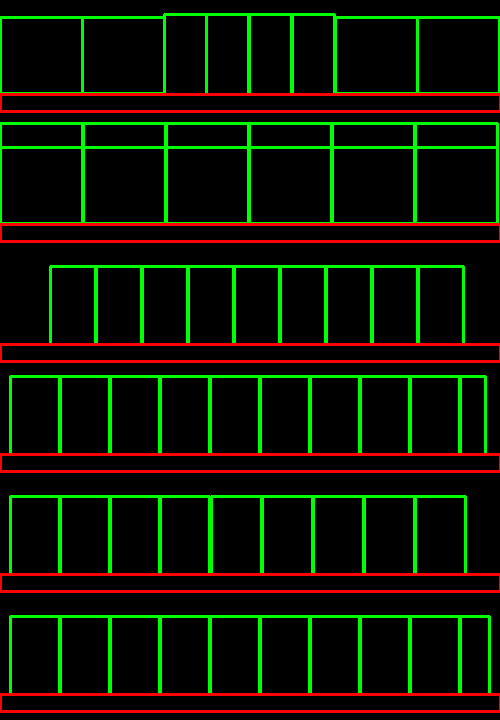

In [12]:
planogram = json.load(open('./resources/sample_planogram.json', 'r'))
viz_planogram = visualize_planogram(planogram, 500)
viz_planogram = cv2.cvtColor(viz_planogram, cv2.COLOR_BGR2RGB)
display(Image.fromarray(viz_planogram))

## Call product recognition

In [9]:
client = ProductRecognitionClient(resource_type, resource_name, multi_service_endpoint, resource_key)
run_name = str(uuid.uuid4())
model_name = 'ms-pretrained-product-detection'
run = ProductRecognition(run_name, model_name)

with open('./resources/sample_image.jpg', 'rb') as f:
    img = f.read()

try:
    client.create_run(run, img, 'image/png')
    result = client.wait_for_completion(run_name, model_name)
finally:
    client.delete_run(run_name, model_name)

INFO:root:Product recognition running fd80f6d1-4f2a-4844-8b43-27a586e25d9a for 2.2742936611175537 seconds. Status ProductRecognitionStatus.RUNNING.
INFO:root:Product recognition running fd80f6d1-4f2a-4844-8b43-27a586e25d9a for 4.540368556976318 seconds. Status ProductRecognitionStatus.RUNNING.
INFO:root:Product recognition running fd80f6d1-4f2a-4844-8b43-27a586e25d9a for 6.803614377975464 seconds. Status ProductRecognitionStatus.RUNNING.
INFO:root:Product recognition running fd80f6d1-4f2a-4844-8b43-27a586e25d9a for 9.070351839065552 seconds. Status ProductRecognitionStatus.RUNNING.
INFO:cognitive_service_vision_model_customization_python_samples.clients.product_recognition_client:Product recognition finished with state ProductRecognitionStatus.SUCCEEDED.
INFO:cognitive_service_vision_model_customization_python_samples.clients.product_recognition_client:Wall-clock time 0.15117253065109254 minutes.
INFO:cognitive_service_vision_model_customization_python_samples.clients.product_recogniti

## Call planogram matching

In [10]:
client = PlanogramComplianceClient(resource_type, resource_name, multi_service_endpoint, resource_key)
matching_request = PlanogramMatchingRequest(result.result, planogram)
result = client.match_planogram(matching_request)